# Neural Network Section

#### Background: Following the link that Peter shared last week: https://hpcquantlib.wordpress.com/2019/01/11/finite-difference-solver-for-the-sabr-model/. The network is trained to fit the difference between the correct SABR volatility from the solution of the partial differential equation and the Floc’h-Kennedy approximation. We need to prepare the dataset first, fortunatelly, the Quantlib has provided some pricing engine and functions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import warnings
import swifter
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn import model_selection
from sklearn.metrics import mean_absolute_error, mean_absolute_error

warnings.filterwarnings('ignore')

### 1. Data Check

In [41]:
df = pd.read_csv('9.18.fdm_hagan_floch_newdata.csv')

In [42]:
df_train = df.query('fdm_vol != 0.1')
df_train['diff'] = df_train['hagan_vol']-df_train['fdm_vol']
df_train = df_train.query('diff>-1 and diff<1')

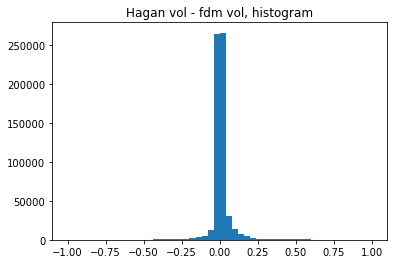

In [43]:
plt.hist(df_train['diff'], bins=50)
plt.title('Hagan vol - fdm vol, histogram')
plt.show()

Most of the time hagan vol is larger than finite difference vol, in very few cases that it is smaller

### 2. Model Training

Crop diff in extreme values, sample 10% to train

In [44]:
df_train['diff'].describe()

count    626824.000000
mean          0.010040
std           0.085761
min          -0.999411
25%          -0.000808
50%           0.000357
75%           0.009184
max           0.999708
Name: diff, dtype: float64

In [62]:
df_train.query("strike>0.9 and strike<1.1 and tenor > 0.9 and tenor < 1.1")['floch_vol'].describe()

count    10732.000000
mean         0.510839
std          0.249136
min          0.098470
25%          0.304860
50%          0.506875
75%          0.711707
max          0.993555
Name: floch_vol, dtype: float64

In [46]:
df_train.query("strike>0.9 and strike<1.1 and tenor > 0.9 and tenor < 1.1")['fdm_vol'].describe()

count    10732.000000
mean         0.510036
std          0.248373
min          0.098672
25%          0.304609
50%          0.506563
75%          0.710625
max          0.998516
Name: fdm_vol, dtype: float64

In [47]:
df_train

,alpha,nu,beta,rho,strike,tenor,hagan_vol,floch_vol,fdm_price,fdm_vol,diff
0,0.1,0.1,0.1,-0.8,0.5,0.25,0.161508,0.161946,0.500000,0.160000,0.001508
2,0.1,0.1,0.1,-0.8,0.5,1.00,0.161555,0.162009,0.500000,0.060000,0.101555
3,0.1,0.1,0.1,-0.8,0.5,3.00,0.161681,0.162176,0.500447,0.162656,-0.000975
4,0.1,0.1,0.1,-0.8,0.5,5.00,0.161807,0.162343,0.502762,0.162656,-0.000849
5,0.1,0.1,0.1,-0.8,0.5,7.00,0.161933,0.162510,0.506791,0.162734,-0.000802
...,...,...,...,...,...,...,...,...,...,...,...
641399,0.9,0.9,1.0,0.1,2.0,3.00,1.247677,1.202304,0.587036,1.194531,0.053145
641403,0.9,0.9,1.0,0.2,2.0,0.25,1.041221,1.036492,0.030128,1.036875,0.004346
641404,0.9,0.9,1.0,0.2,2.0,0.50,1.067594,1.058136,0.097278,1.059531,0.008063
641405,0.9,0.9,1.0,0.2,2.0,1.00,1.120341,1.101425,0.232208,1.105234,0.015107


In [48]:
y = df_train['diff']
x = df_train[['alpha', 'nu', 'beta', 'rho', 'strike', 'tenor', 'hagan_vol']]
x_train, x_test, y_train, y_test=model_selection.train_test_split(x, y, test_size=0.25)

x_train=torch.tensor(x_train.values,dtype=torch.float)
x_test=torch.tensor(x_test.values,dtype=torch.float)
y_train=torch.tensor(y_train.values,dtype=torch.float)
y_test=torch.tensor(y_test.values,dtype=torch.float)

In [49]:
model=torch.nn.Sequential(
        torch.nn.Linear(7,20),
        torch.nn.Linear(20,100),
        torch.nn.Linear(100,400),
        torch.nn.Sigmoid(),
        torch.nn.Linear(400,10),
        torch.nn.Tanh(),
        torch.nn.Linear(10,1),
        torch.nn.Tanh())

optimizer=optim.Adam(model.parameters(), lr=0.001)
n_epochs = 80
batch_size = 64

train_dataset = torch.utils.data.TensorDataset(x_train, y_train.view(-1, 1))
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

In [50]:
for epoch in range(n_epochs):
    for i, (features, price) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(features.float())
        loss = torch.nn.functional.mse_loss(output,price)
        loss.backward()
        optimizer.step()

In [51]:
def check_accuracy(y, y_hat, moneyness):
    stats = dict()
    
    stats['diff'] = y - y_hat
    stats['Error percent']=np.abs(y-y_hat)/y*100
    
    stats['mse'] = np.mean(stats['diff']**2)
    print("Mean Squared Error:      ", stats['mse'])
    
    stats['rmse'] = np.sqrt(stats['mse'])
    print("Root Mean Squared Error: ", stats['rmse'])
    
    stats['mae'] = np.mean(abs(stats['diff']))
    print("Mean Absolute Error:     ", stats['mae'])
    
    # plots
    plt.rcParams['agg.path.chunksize'] = 100000
    plt.figure(figsize=(14,10))
    plt.scatter(y, y_hat,color='black',linewidth=0.3,alpha=0.4, s=1.5)
    plt.xlabel('Actual Diff',fontsize=20,fontname='Times New Roman')
    plt.ylabel('Predicted Diff',fontsize=20,fontname='Times New Roman') 
    plt.show()
    
    plt.rcParams['agg.path.chunksize'] = 100000
    plt.figure(figsize=(14,10))
    plt.scatter(moneyness, stats['Error percent'],color='black',linewidth=0.3)
    plt.xlabel('Moneyness',fontsize=20,fontname='Times New Roman')
    plt.ylabel('Absolute error percent',fontsize=20,fontname='Times New Roman') 
    plt.show()
    
    plt.figure(figsize=(14,10))
    plt.hist(stats['diff'], bins=50,edgecolor='black',color='white')
    plt.xlabel('Diff')
    plt.ylabel('Density')
    plt.show()
    return stats

### 3. Model Predicting

Mean Squared Error:       0.00066416676
Root Mean Squared Error:  0.025771433
Mean Absolute Error:      0.010771795


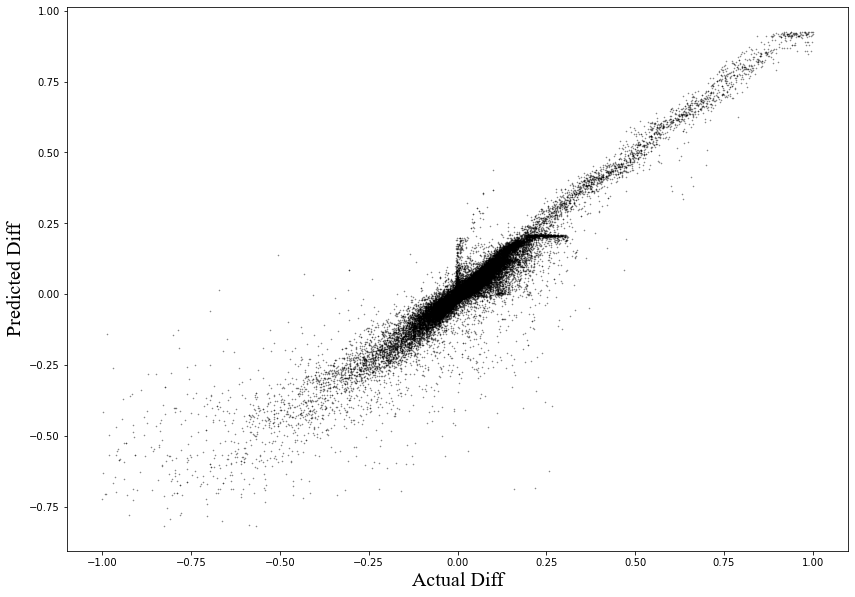

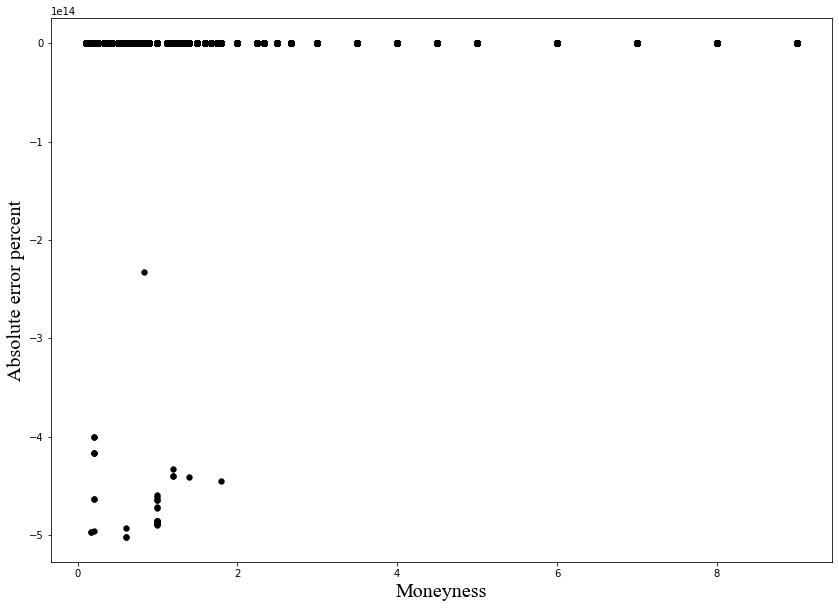

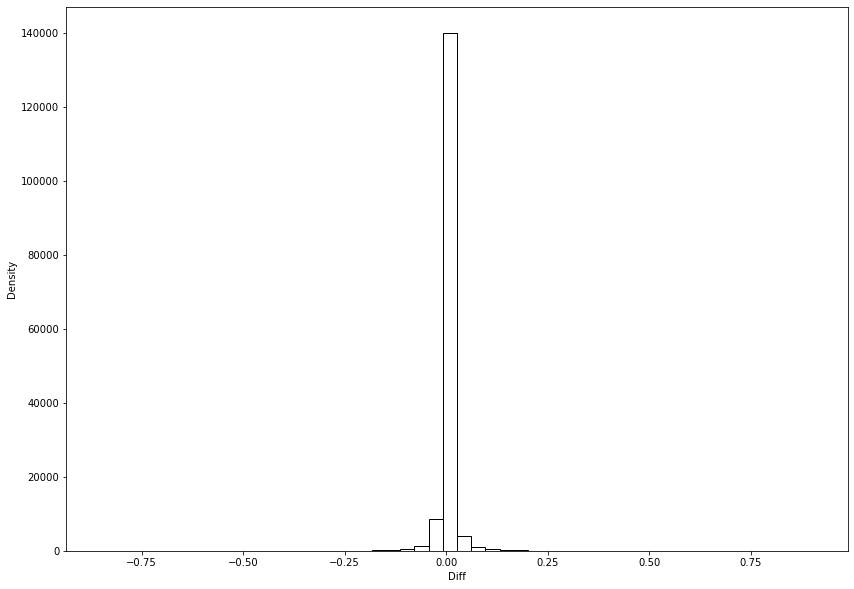

{'diff': array([ 0.00683723,  0.00432015,  0.00550226, ..., -0.00893643,
         0.00462838,  0.00550507], dtype=float32),
 'Error percent': array([-1862.7273 ,  -149.61845,   497.51776, ...,   149.07642,
         4225.0303 ,   875.9162 ], dtype=float32),
 'mse': 0.00066416676,
 'rmse': 0.025771433,
 'mae': 0.010771795}

In [52]:
y_test_hat = np.squeeze(model(x_test))
y_test_np = y_test.numpy()
y_test_hat_np = y_test_hat.detach().numpy()
check_accuracy(y_test_np, y_test_hat_np, x_test.numpy()[:,1]/x_test.numpy()[:,0])

### 4. Post Evaluation

In [53]:
def draw_trisurf(x, y, z, title, x_axis='K', y_axis='T'):
    fig = plt.figure(figsize =(16, 9))  
    ax = plt.axes(projection ='3d')  

    # Creating color map
    my_cmap = plt.get_cmap('RdBu_r')

    # Creating plot
    trisurf = ax.plot_trisurf(x, y, z,
                             cmap = my_cmap,
                             linewidth = 0.2, 
                             antialiased = True,
                             edgecolor = 'grey')  
    fig.colorbar(trisurf, ax = ax, shrink = 0.5, aspect = 5)
    ax.set_title(title)
    ax.set_xlabel(x_axis, fontsize=15, rotation=60)
    ax.set_ylabel(y_axis, fontsize=15, rotation=60)
    ax.set_zlabel(title, fontsize=15)
    plt.show()

                   0
count  626824.000000
mean        0.017716
std         0.029103
min         0.000000
25%         0.000557
50%         0.003475
75%         0.019183
max         0.100000


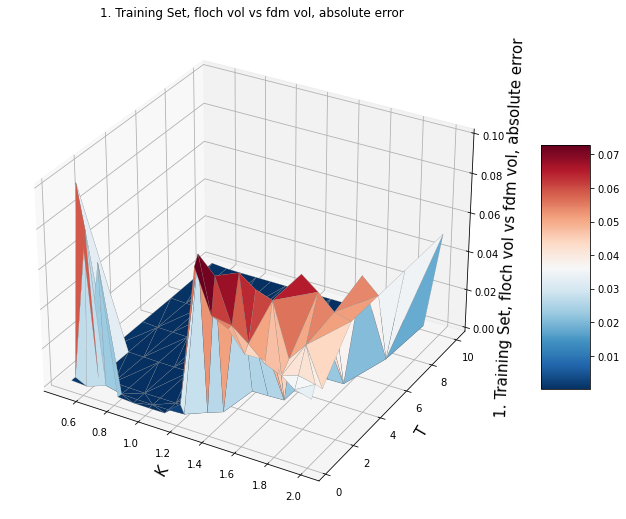

In [54]:
z = np.abs(np.array(df_train['diff']))
for i in range(0, len(z), 1):
    if z[i] > 0.1:
        z[i] = 0.1
x = df_train['strike']
y = df_train['tenor']
print(pd.DataFrame(z).describe())
draw_trisurf(x, y, z, '1. Training Set, floch vol vs fdm vol, absolute error')

                   0
count  156706.000000
mean        0.017767
std         0.029149
min         0.000000
25%         0.000551
50%         0.003480
75%         0.019310
max         0.100000


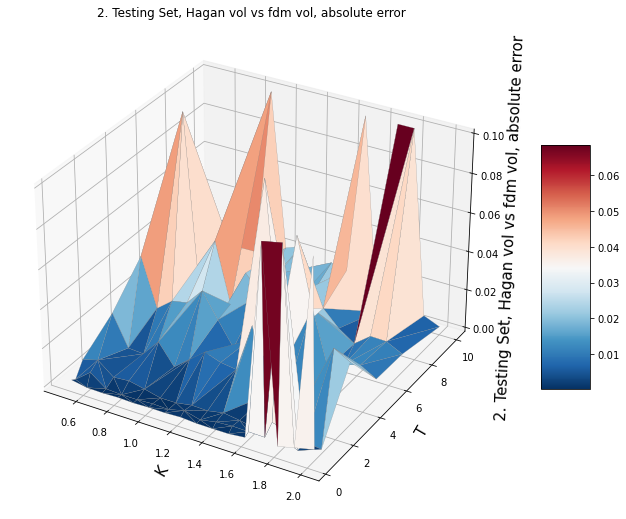

In [55]:
z = np.abs(y_test.detach().numpy())
for i in range(0, len(z), 1):
    if z[i] > 0.1:
        z[i] = 0.1
x = x_test.detach().numpy()[:, 4]
y = x_test.detach().numpy()[:, 5]
print(pd.DataFrame(z).describe())
draw_trisurf(x, y, z, '2. Testing Set, Hagan vol vs fdm vol, absolute error')

As we can see, train and test data have similar property. Therefore we are going to analyze the test data in the following sessions.

                   0
count  156706.000000
mean        5.220916
std        12.047737
min         0.000000
25%         0.126441
50%         0.848597
75%         4.087696
max       100.000000


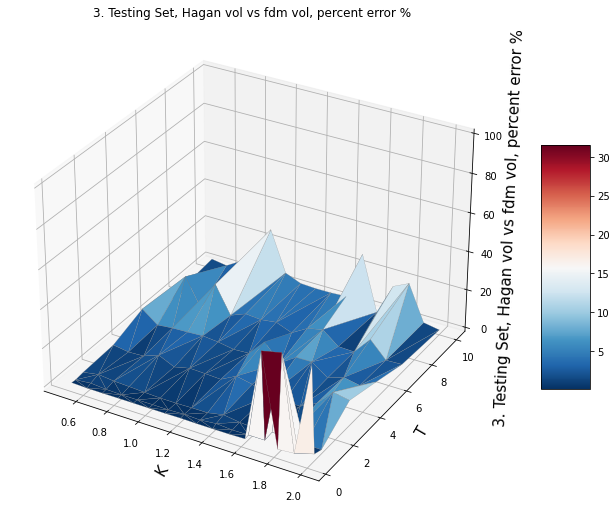

In [56]:
z = np.abs(y_test.detach().numpy() / (x_test.detach().numpy()[:, 6] - y_test.detach().numpy())) * 100
for i in range(0, len(z), 1):
    if z[i] > 100:
        z[i] = 100
x = x_test.detach().numpy()[:, 4]
y = x_test.detach().numpy()[:, 5]
print(pd.DataFrame(z).describe())
draw_trisurf(x, y, z, '3. Testing Set, Hagan vol vs fdm vol, percent error %')

                  0
count  1.567060e+05
mean   9.896293e-03
std    1.422268e-02
min    1.245644e-07
25%    4.392980e-03
50%    5.353813e-03
75%    9.250701e-03
max    1.000000e-01


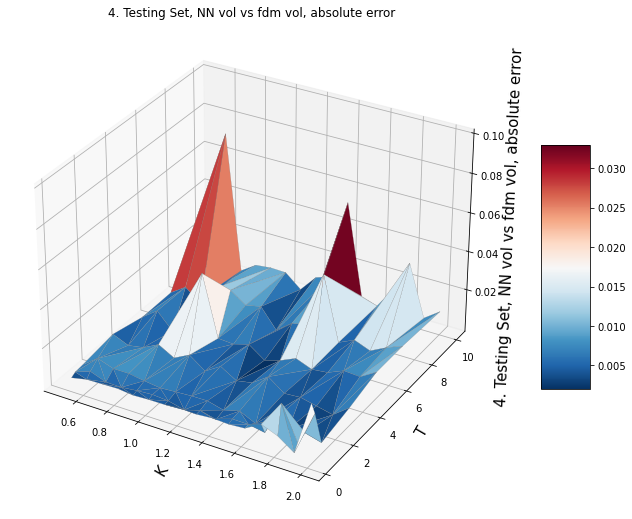

In [57]:
z = np.abs((y_test.detach().numpy() - y_test_hat.detach().numpy()))
for i in range(0, len(z), 1):
    if z[i] > 0.1:
        z[i] = 0.1
x = x_test.detach().numpy()[:, 4]
y = x_test.detach().numpy()[:, 5]
print(pd.DataFrame(z).describe())
draw_trisurf(x, y, z, '4. Testing Set, NN vol vs fdm vol, absolute error')

                   0
count  156706.000000
mean        4.349996
std        13.394674
min         0.000034
25%         0.774136
50%         1.318042
75%         2.690100
max       100.000000


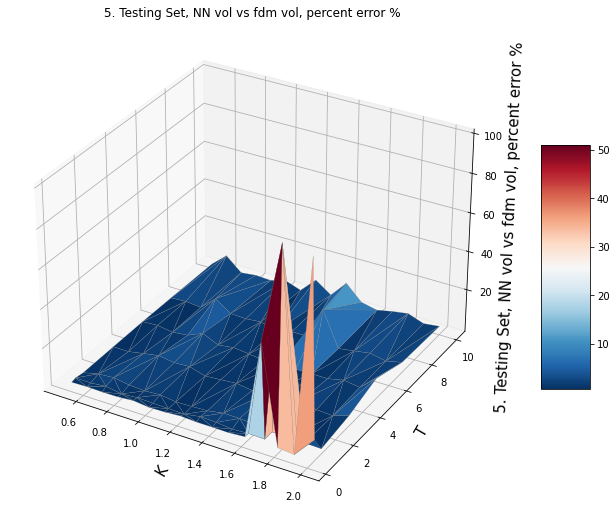

In [69]:
z = np.abs((y_test.detach().numpy() - y_test_hat.detach().numpy())) / (x_test.detach().numpy()[:, 6] - y_test.detach().numpy()) * 100
for i in range(0, len(z), 1):
    if z[i] > 100:
        z[i] = 100
x = x_test.detach().numpy()[:, 4]
y = x_test.detach().numpy()[:, 5]
print(pd.DataFrame(z).describe())
draw_trisurf(x, y, z, '5. Testing Set, NN vol vs fdm vol, percent error %')

                   0
count  156706.000000
mean        4.349996
std        13.394674
min         0.000034
25%         0.774136
50%         1.318042
75%         2.690100
max       100.000000


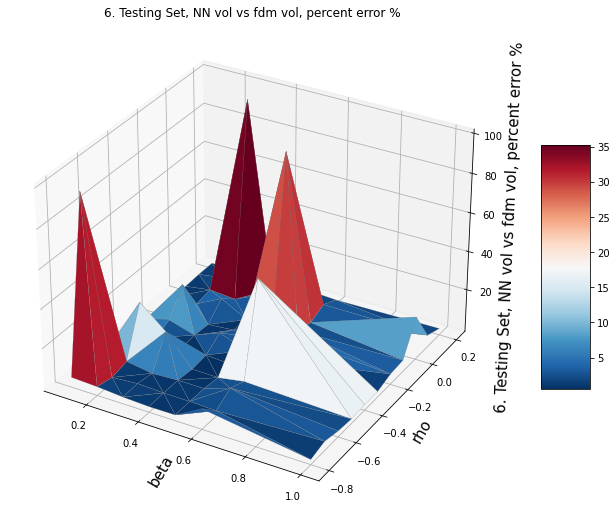

In [70]:
z = np.abs((y_test.detach().numpy() - y_test_hat.detach().numpy())) / (x_test.detach().numpy()[:, 6] - y_test.detach().numpy()) * 100
for i in range(0, len(z), 1):
    if z[i] > 100:
        z[i] = 100
x = x_test.detach().numpy()[:, 2]
y = x_test.detach().numpy()[:, 3]
print(pd.DataFrame(z).describe())
draw_trisurf(x, y, z, '6. Testing Set, NN vol vs fdm vol, percent error %', 'beta', 'rho')

As a result, the Neural Network can significantlt reduce the mean percentage error. There are some regions where T is small, NN still has a large absolute and percent error.
This is an area which we can improve in the future.